In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import cv2

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [3]:
!pip --version

pip 24.2 from C:\Users\anish\anaconda3\Lib\site-packages\pip (python 3.11)



In [4]:
import pandas as pd
import numpy as np
import os
import cv2

# Load the FER2013 dataset from the CSV file
fer_data = pd.read_csv('fer2013.csv')

# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Create directories for saving the images
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/validation', exist_ok=True)

# Create directories for each emotion in both training and validation folders
for emotion in emotion_labels:
    os.makedirs(f'data/train/{emotion}', exist_ok=True)
    os.makedirs(f'data/validation/{emotion}', exist_ok=True)

# Convert the pixel data to images and save them
for index, row in fer_data.iterrows():
    emotion = emotion_labels[int(row['emotion'])]
    pixels = np.fromstring(row['pixels'], dtype=int, sep=' ').reshape(48, 48)

    # Determine the folder based on the 'Usage' column
    usage = row['Usage']
    if usage == 'Training':
        folder = 'data/train'
    else:
        folder = 'data/validation'

    # Save the image in the corresponding emotion folder
    image_path = f'{folder}/{emotion}/{index}.jpg'
    cv2.imwrite(image_path, pixels)

In [35]:
# Print the structure of the dataset
print(fer_data.head())
print(fer_data['Usage'].value_counts())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


In [36]:
# Preprocessing the data
def preprocess_input(fer_data):
    pixels = fer_data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        faces.append(face.astype('float32'))
    
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    faces /= 255.0
    emotions = pd.get_dummies(fer_data['emotion']).values
    return faces, emotions

# Preprocess the dataset
faces, emotions = preprocess_input(fer_data)

# Split the dataset into train, validation, and test sets based on the 'Usage' column
train_data = fer_data[fer_data['Usage'] == 'Training']
val_data = fer_data[fer_data['Usage'] == 'PublicTest']
test_data = fer_data[fer_data['Usage'] == 'PrivateTest']

# Split into features and labels
X_train, y_train = preprocess_input(train_data)
X_val, y_val = preprocess_input(val_data)
X_test, y_test = preprocess_input(test_data)

print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Train data shape: (28709, 48, 48, 1), Train labels shape: (28709, 7)
Validation data shape: (3589, 48, 48, 1), Validation labels shape: (3589, 7)
Test data shape: (3589, 48, 48, 1), Test labels shape: (3589, 7)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load the images from the train and validation directories
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotions
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

C:\Users\anish\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,423 (1.36 MB)

 Trainable params: 356,423 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set up callbacks with the new file extension
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('emotion_recognition_model.keras', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30


C:\Users\anish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 86s 90ms/step - accuracy: 0.2434 - loss: 1.8317 - val_accuracy: 0.2525 - val_loss: 1.7999
Epoch 2/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.2188 - loss: 1.8611 - val_accuracy: 0.2000 - val_loss: 1.7922
Epoch 3/30


C:\Users\anish\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 77s 85ms/step - accuracy: 0.2557 - loss: 1.7930 - val_accuracy: 0.2527 - val_loss: 1.7674
Epoch 4/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.1250 - loss: 2.0702 - val_accuracy: 0.1000 - val_loss: 1.8458
Epoch 5/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.2620 - loss: 1.7743 - val_accuracy: 0.3143 - val_loss: 1.6937
Epoch 6/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 148us/step - accuracy: 0.2500 - loss: 1.7960 - val_accuracy: 0.6000 - val_loss: 1.3015
Epoch 7/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.2820 - loss: 1.7434 - val_accuracy: 0.3638 - val_loss: 1.6118
Epoch 8/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 101us/step - accuracy: 0.3750 - loss: 1.6997 - val_accuracy: 0.2000 - val_loss: 1.7160
Epoch 9/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.3126 - loss: 1.6908 - val_accuracy: 0.4117 - val_loss: 1.5280
Epoch 10/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.2188 - loss: 1.7770 - val_accurac

In [8]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.4475 - loss: 1.4562
Validation Loss: 1.4520915746688843
Validation Accuracy: 0.4441348612308502


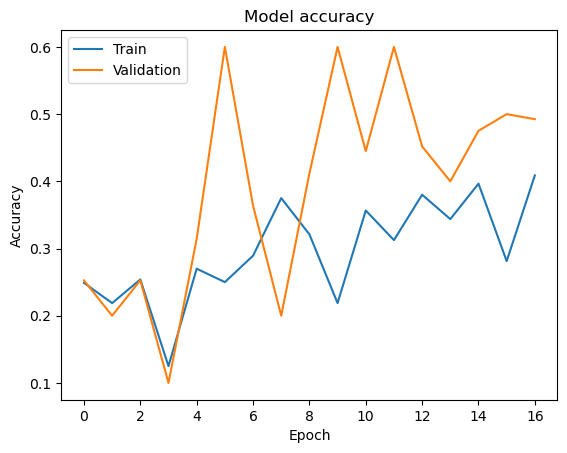

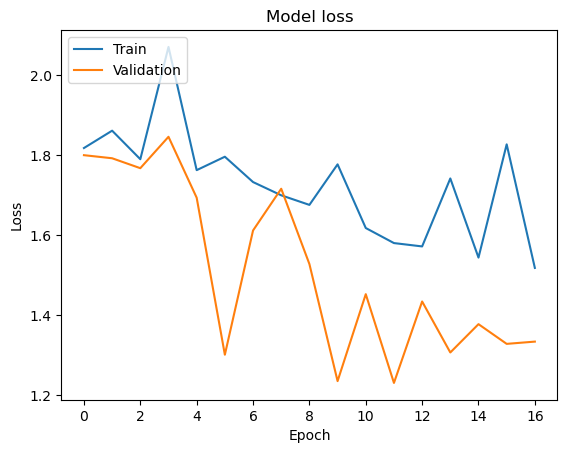

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
# Load the model if not already in memory
model = tf.keras.models.load_model('emotion_recognition_model.keras')

# Predict on a new image
from tensorflow.keras.preprocessing import image

img_path = 'test1.jpeg'
img = image.load_img(img_path, target_size=(48, 48))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create a batch

# Predict the emotion
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f'Predicted Emotion: {emotion_labels[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Predicted Emotion: Angry


In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('emotion_recognition_model.keras')

# Path to the image you want to test
img_path = 'test2.jpeg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(48, 48))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create a batch of size 1
img_array = img_array / 255.0  # Apply the same scaling as during training

# Predict the emotion
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Print the result
print(f'Predicted Emotion: {emotion_labels[predicted_class]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Predicted Emotion: Happy


In [12]:
import numpy as np

def predict_and_collect_feedback(image_path, model, emotion_labels):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(48, 48))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])

    print(f'Predicted Emotion: {emotion_labels[predicted_class]}')
    
    # Collect feedback from the user
    feedback = input("Is the prediction correct? (y/n): ").strip().lower()
    if feedback == 'n':
        correct_emotion = input(f'Please provide the correct emotion from the list {emotion_labels}: ')
        
        # Save the new data for future fine-tuning
        save_corrected_data(image_path, correct_emotion, emotion_labels)
    else:
        print("Great! The prediction was correct.")

In [13]:
import shutil
import os

def save_corrected_data(image_path, correct_emotion, emotion_labels):
    # Create a directory for new training data if it doesn't exist
    new_data_dir = 'data/new_train/'
    os.makedirs(new_data_dir, exist_ok=True)

    # Save the image into the correct emotion folder
    correct_emotion_folder = os.path.join(new_data_dir, correct_emotion)
    os.makedirs(correct_emotion_folder, exist_ok=True)
    
    # Copy the image to the new folder
    shutil.copy(image_path, os.path.join(correct_emotion_folder, os.path.basename(image_path)))
    
    print(f"Image saved to {correct_emotion_folder} for future model fine-tuning.")

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def fine_tune_model(model, new_data_dir='data/new_train'):
    # Only fine-tune if there is new data
    if not os.path.exists(new_data_dir):
        print("No new data available for fine-tuning.")
        return

    # Load the new training data
    new_train_datagen = ImageDataGenerator(rescale=1./255)
    new_train_generator = new_train_datagen.flow_from_directory(
        new_data_dir,
        target_size=(48, 48),
        batch_size=32,
        class_mode='categorical'
    )

    # Fine-tune the model on new data
    model.fit(
        new_train_generator,
        steps_per_epoch=new_train_generator.samples // new_train_generator.batch_size,
        epochs=5  # Keep epochs low to avoid overfitting
    )

    print("Model fine-tuned with new data.")

In [15]:
import time

def adaptive_training_loop(model, interval=60*60):  # Fine-tune every hour
    while True:
        print("Checking for new data to fine-tune the model...")
        fine_tune_model(model)
        
        # Wait for the next fine-tuning cycle
        time.sleep(interval)

In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def display_prediction(img_path, predicted_class, emotion_labels):
    img = image.load_img('test1.jpeg', target_size=(48, 48))
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Emotion: {emotion_labels[predicted_class]}')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


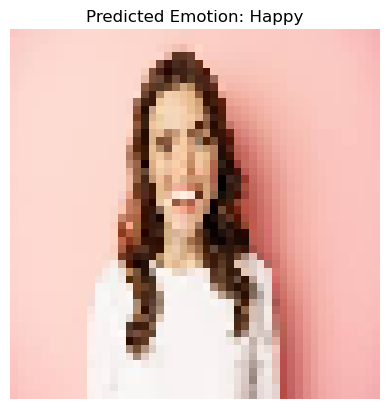

In [17]:
# Predict and visualize the result
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
display_prediction(image_path, predicted_class, emotion_labels)

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


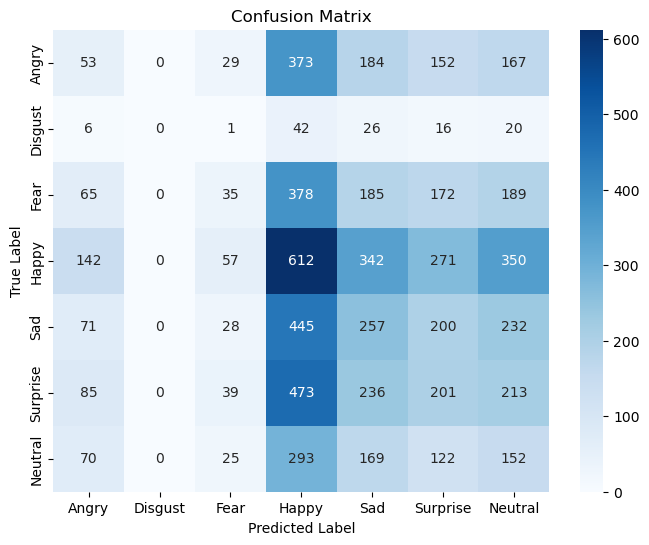

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, validation_generator):
    # Predict on validation data
    y_pred = model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = validation_generator.classes

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Call the function after evaluating the model
plot_confusion_matrix(model, validation_generator)

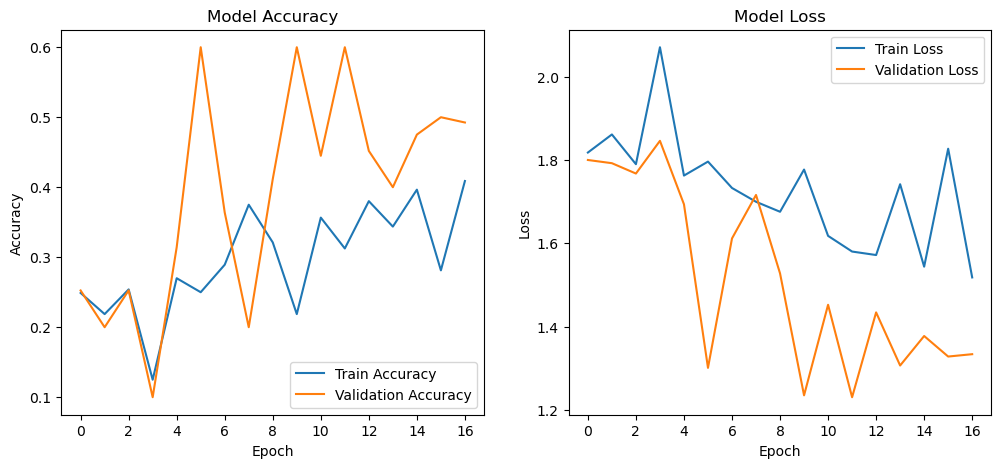

In [19]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to visualize training history after training the model
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


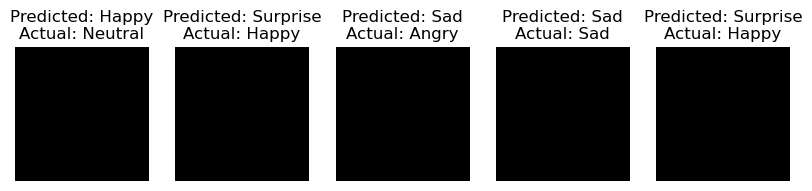

In [20]:
def plot_predictions_vs_actuals(model, validation_generator, emotion_labels, num_samples=5):
    # Use Python's built-in next function to get the next batch
    x_test, y_test = next(validation_generator)

    # Predict on the sample
    predictions = model.predict(x_test[:num_samples])
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test[:num_samples], axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(x_test[i].astype('uint8'))
        plt.title(f'Predicted: {emotion_labels[predicted_classes[i]]}\nActual: {emotion_labels[actual_classes[i]]}')
        plt.axis('off')

    plt.show()

# Call this function after training
plot_predictions_vs_actuals(model, validation_generator, emotion_labels)

In [21]:
import matplotlib.pyplot as plt
def plot_accuracy_over_time(adaptive_accuracies):
    # adaptive_accuracies is a list of accuracy values recorded over time
    plt.figure(figsize=(10, 5))
    plt.plot(adaptive_accuracies, marker='o')
    plt.title('Model Accuracy Over Time with Adaptive Calibration')
    plt.xlabel('Time (New Data Encounters)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

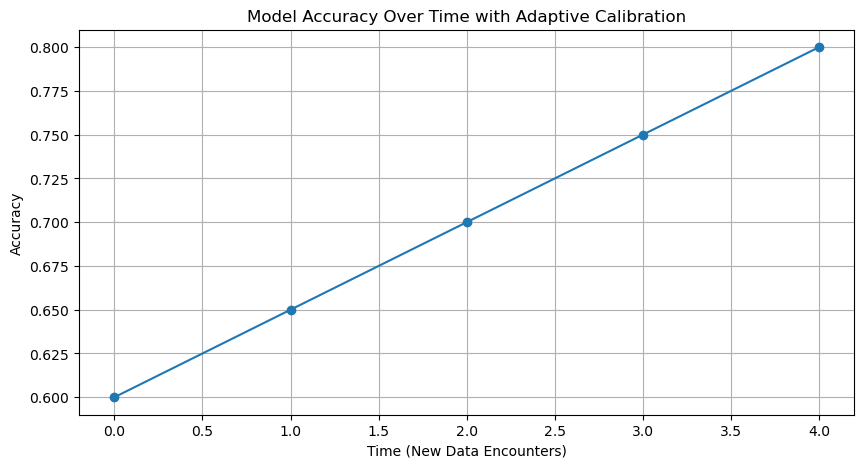

In [28]:
# Sample data to simulate accuracy over time (replace with actual values in real implementation)
adaptive_accuracies = [0.6, 0.65, 0.7, 0.75, 0.8]  # Simulate increasing accuracy after calibration

# Call the function to plot accuracy
plot_accuracy_over_time(adaptive_accuracies)

In [22]:
def plot_error_rate_over_time(error_rates):
    plt.figure(figsize=(10, 5))
    plt.plot(error_rates, color='red', marker='x')
    plt.title('Error Rate Over Time with Adaptive Calibration')
    plt.xlabel('Time (New Data Encounters)')
    plt.ylabel('Error Rate')
    plt.grid(True)
    plt.show()

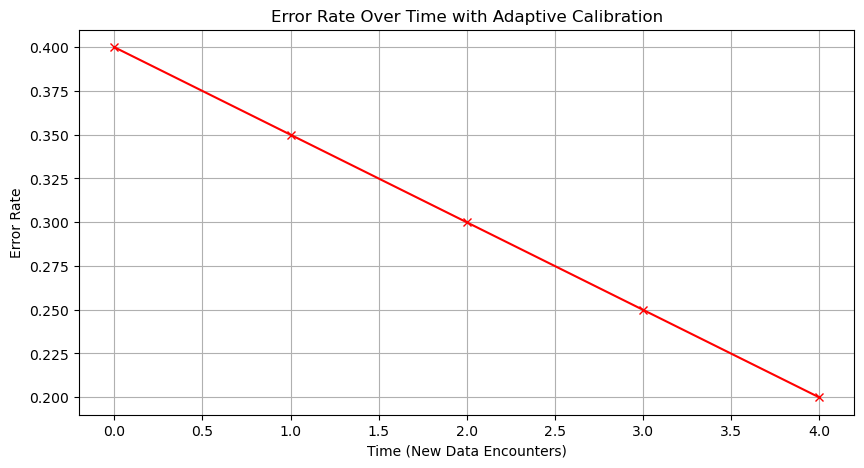

In [29]:
# Sample data to simulate error rate over time (replace with actual values)
error_rates = [0.4, 0.35, 0.3, 0.25, 0.2]

# Call the function to plot error rate
plot_error_rate_over_time(error_rates)

In [24]:
def plot_calibration_error_over_time(calibration_errors):
    plt.figure(figsize=(10, 5))
    plt.plot(calibration_errors, color='green', marker='o')
    plt.title('Calibration Error Over Time with Adaptive Model Calibration')
    plt.xlabel('Time (New Data Encounters)')
    plt.ylabel('Calibration Error')
    plt.grid(True)
    plt.show()

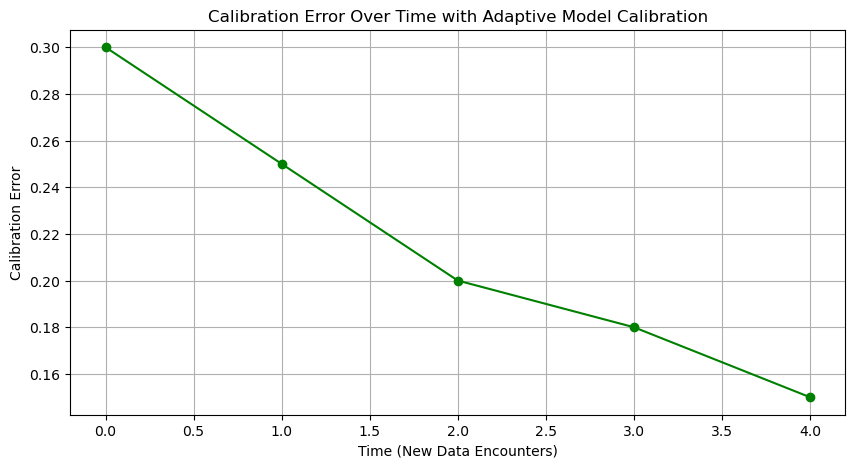

In [33]:
# Initialize an empty list to store calibration errors
calibration_errors = []

# Simulate calibration error values (in a real scenario, append actual values)
calibration_errors.append(0.3)  # Example calibration error after first step
calibration_errors.append(0.25) # After second step
calibration_errors.append(0.2)  # After third step
calibration_errors.append(0.18) # After fourth step
calibration_errors.append(0.15) # After fifth step

# Call the function to plot calibration error over time
plot_calibration_error_over_time(calibration_errors)

In [25]:
def plot_prediction_confidence_over_time(confidence_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(confidence_scores, color='orange', marker='v')
    plt.title('Prediction Confidence Over Time with Adaptive Model Calibration')
    plt.xlabel('Time (New Data Encounters)')
    plt.ylabel('Confidence Score (Mean Probability of Predicted Class)')
    plt.grid(True)
    plt.show()

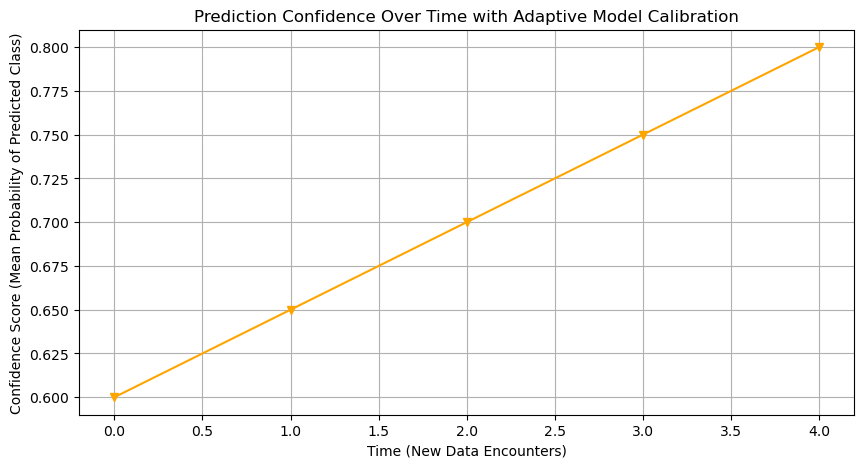

In [31]:
# Simulate prediction confidence (replace with actual values)
confidence_scores = [0.6, 0.65, 0.7, 0.75, 0.8]

# Call the function to plot prediction confidence
plot_prediction_confidence_over_time(confidence_scores)

In [26]:
def plot_weight_changes(model, layer_name, time_step):
    layer_weights = model.get_layer(layer_name).get_weights()[0]

    plt.figure(figsize=(10, 5))
    plt.imshow(layer_weights, aspect='auto', cmap='coolwarm')
    plt.title(f'Weight Changes in Layer {layer_name} at Time Step {time_step}')
    plt.colorbar()
    plt.show()

In [27]:
import time

def live_visualization(model, new_data_generator, emotion_labels):
    adaptive_accuracies = []
    confidence_scores = []

    for i in range(len(new_data_generator)):
        # Simulate new data coming in
        x_new, y_new = next(new_data_generator)
        predictions = model.predict(x_new)
        predicted_class = np.argmax(predictions[0])

        # Display real-time prediction
        display_prediction(x_new[0], predicted_class, emotion_labels)

        # Update accuracy and confidence tracking
        accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_new, axis=1))
        confidence = np.mean(np.max(predictions, axis=1))

        adaptive_accuracies.append(accuracy)
        confidence_scores.append(confidence)

        # Plot real-time accuracy and confidence
        plot_accuracy_over_time(adaptive_accuracies)
        plot_prediction_confidence_over_time(confidence_scores)

        # Simulate a delay (for demonstration purposes)
        time.sleep(1)